# Install these librarires if you havent already

In [4]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# If you wanted to run streamlit main.py
## Run the below code block only

In [8]:
!python -m streamlit run main.py

^C


# If you want to run streamlit main.py with an excel file
## Run the below code block

count     119.0
unique     61.0
top        61.5
freq        5.0
Name: ราคาปิด, dtype: float64
        วันที่ ราคาเปิด ราคาสูงสุด ราคาต ่าสุด ราคาเฉลี่ย ราคาปิด เปลี่ยนแปลง  \
113 2024-12-03    61.75         62       61.25      61.74      62        0.25   

    เปลี่ยนแปลง(%) ปริมาณ(พันหุ้น) มูลค่า(ล้านบาท) SET Index  \
113            0.4        13052.88          805.83   1454.76   

    SET เปลี่ยนแปลง(%)  
113               1.23  
            ราคาปิด  SET Index
ราคาปิด    1.000000   0.956706
SET Index  0.956706   1.000000


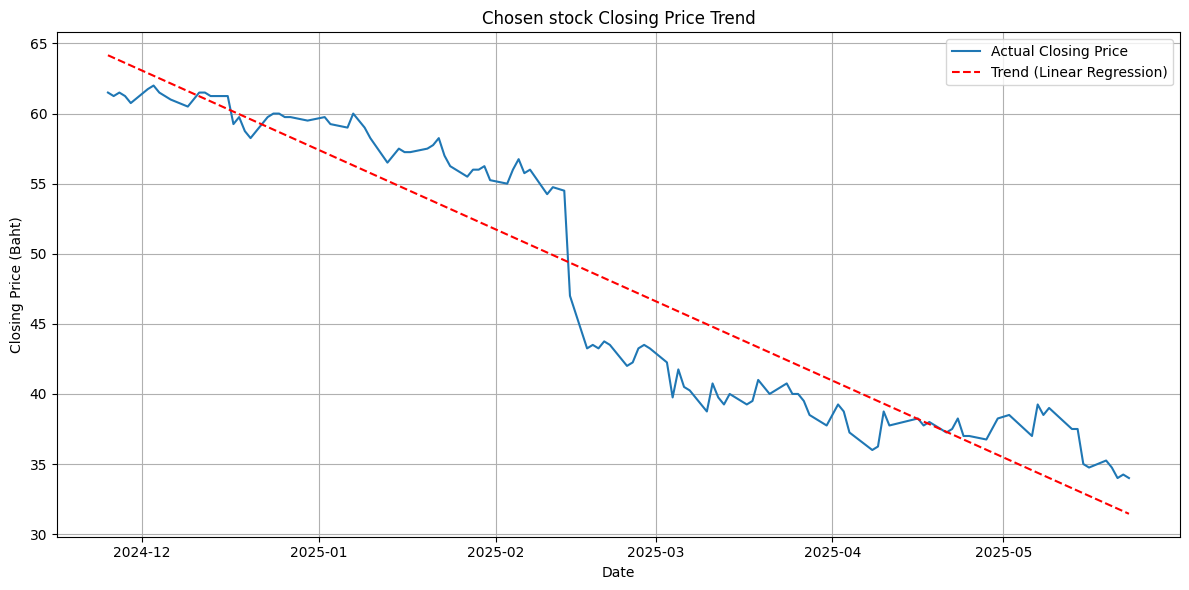

Python 


<Figure size 640x480 with 0 Axes>

In [ ]:
import sys
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

try:
    df = pd.read_excel("Stocks.xlsx", sheet_name="Stocks", skiprows=1)
except FileNotFoundError:
    print("The file cannot be found!")
    sys.exit()

df.columns = [
"วันที่", "ราคาเปิด", "ราคาสูงสุด", "ราคาต ่าสุด", "ราคาเฉลี่ย", "ราคาปิด",
"เปลี่ยนแปลง", "เปลี่ยนแปลง(%)", "ปริมาณ(พันหุ้น)", "มูลค่า(ล้านบาท)",
"SET Index", "SET เปลี่ยนแปลง(%)"
]
thai_months = {
"ม.ค.": "01", "ก.พ.": "02", "มี.ค.": "03", "เม.ย.": "04",
"พ.ค.": "05", "มิ.ย.": "06", "ก.ค.": "07", "ส.ค.": "08",
"ก.ย.": "09", "ต.ค.": "10", "พ.ย.": "11", "ธ.ค.": "12"
}
def convert_thai_date(thai_date_str):
    for th, num in thai_months.items():
        if th in thai_date_str:
            day, month_th, year_th = thai_date_str.replace(",", "").split()
            month = thai_months[month_th]
            year = int(year_th) - 543
            return f"{year}-{month}-{int(day):02d}"
    return None

df = df[~df["วันที่"].isna() & ~df["วันที่"].str.contains("วันที่")]
df["วันที่"] = df["วันที่"].apply(convert_thai_date)
df["วันที่"] = pd.to_datetime(df["วันที่"])
df = df.dropna()
df.head(5)


print(df["ราคาปิด"].describe())
print(df[df["ราคาปิด"] == df["ราคาปิด"].max()])
print(df[["ราคาปิด", "SET Index"]].corr())


matplotlib.rcParams['font.family'] = 'DejaVu Sans'
df_sorted = df.sort_values("วันที่")
X = df_sorted["วันที่"].map(pd.Timestamp.toordinal).to_numpy().reshape(-1, 1)
y = df_sorted["ราคาปิด"].astype(float).to_numpy()

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(df_sorted["วันที่"], y, label="Actual Closing Price")
plt.plot(df_sorted["วันที่"], trend, label="Trend (Linear Regression)", linestyle="--", color="red")
plt.title("Chosen stock Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Closing Price (Baht)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the plot as an image
plt.savefig("Stock-results.png")

# Save the data (date, actual, trend) to CSV
output_df = pd.DataFrame({
    "Date": df_sorted["วันที่"].dt.strftime("%Y-%m-%d"),
    "Closing price": y,
    "Trend": trend
})
output_df.to_csv("Stock-results.csv", index=False)

!python -m streamlit run main.py